<a href="https://colab.research.google.com/github/Chandak0701/EatAi/blob/master/salesforecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

In [2]:
df = pd.read_csv('archive.csv', parse_dates=['Date'])

In [3]:
df_weekly = df.groupby(pd.Grouper(key='Date', freq='W')).agg(
    {'Amount ($)': 'sum', 'Quantity': 'sum', 'Unit Price ($)': 'mean'}).reset_index().rename(columns={'Amount ($)': 'Sales'})
df_monthly = df.groupby(pd.Grouper(key='Date', freq='M')).agg(
    {'Amount ($)': 'sum', 'Quantity': 'sum', 'Unit Price ($)': 'mean'}).reset_index().rename(columns={'Amount ($)': 'Sales'})

/tmp/ipython-input-1360563761.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.groupby(pd.Grouper(key='Date', freq='M')).agg(


In [4]:
def show_stationarity(series, label):
    adf = adfuller(series)
    kpss_val = kpss(series, nlags='auto')
    print(f"{label} | ADF: Statistic={adf[0]:.2f}, p={adf[1]:.4f}; KPSS: Statistic={kpss_val[0]:.2f}, p={kpss_val[1]:.4f}")

In [5]:
def show_stationarity(series, label):
    adf = adfuller(series)
    kpss_val = kpss(series, nlags='auto')
    print(f"{label} | ADF: Statistic={adf[0]:.2f}, p={adf[1]:.4f}; KPSS: Statistic={kpss_val[0]:.2f}, p={kpss_val[1]:.4f}")


In [6]:
show_stationarity(df_weekly['Sales'], 'Weekly Sales')
show_stationarity(df_monthly['Sales'], 'Monthly Sales')

Weekly Sales | ADF: Statistic=-5.59, p=0.0000; KPSS: Statistic=0.11, p=0.1000
Monthly Sales | ADF: Statistic=-2.36, p=0.1546; KPSS: Statistic=0.19, p=0.1000


/tmp/ipython-input-2079672367.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_val = kpss(series, nlags='auto')
/tmp/ipython-input-2079672367.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_val = kpss(series, nlags='auto')


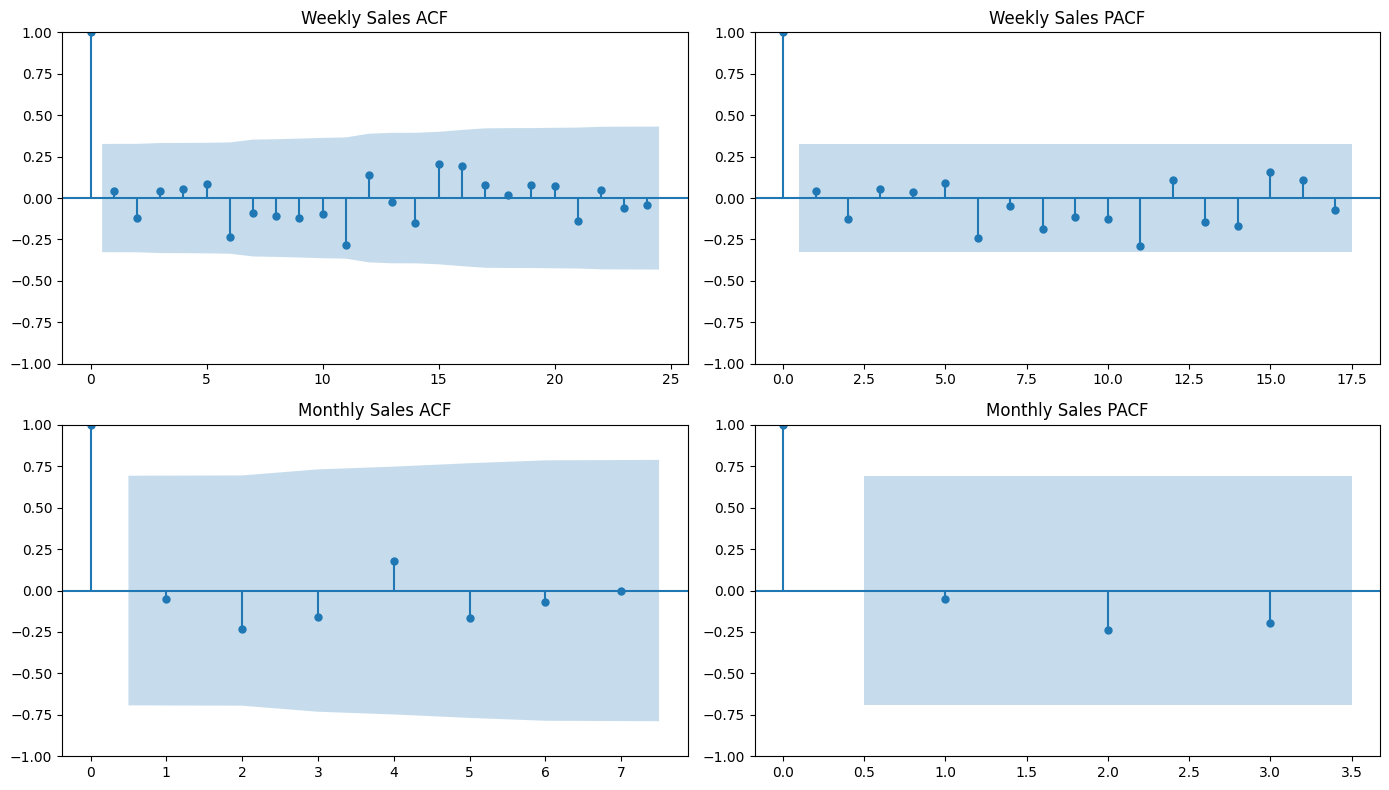

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
plot_acf(df_weekly['Sales'], lags=24, ax=axs[0,0])
axs[0,0].set_title('Weekly Sales ACF')
plot_pacf(df_weekly['Sales'], lags=17, ax=axs[0,1])
axs[0,1].set_title('Weekly Sales PACF')
plot_acf(df_monthly['Sales'], lags=7, ax=axs[1,0])
axs[1,0].set_title('Monthly Sales ACF')
plot_pacf(df_monthly['Sales'], lags=3, ax=axs[1,1])
axs[1,1].set_title('Monthly Sales PACF')
plt.tight_layout()
plt.show()

In [10]:
n_test_weekly = 12
train_w = df_weekly.iloc[:-n_test_weekly]
test_w = df_weekly.iloc[-n_test_weekly:]
exog_cols = ['Quantity', 'Unit Price ($)']
train_exog_w = train_w[exog_cols]
test_exog_w = test_w[exog_cols]

n_test_monthly = 2
train_m = df_monthly.iloc[:-n_test_monthly]
test_m = df_monthly.iloc[-n_test_monthly:]
train_exog_m = train_m[exog_cols]
test_exog_m = test_m[exog_cols]

In [11]:
sarimax_w = SARIMAX(train_w['Sales'], exog=train_exog_w, order=(1,1,1), seasonal_order=(1,1,1,52)).fit(disp=False)
forecast_w = sarimax_w.forecast(steps=n_test_weekly, exog=test_exog_w)
mae_w = mean_absolute_error(test_w['Sales'], forecast_w)
print('Weekly SARIMAX - MAE:', mae_w)
print('Actual weekly sales:', test_w['Sales'].values)
print('Forecast weekly sales:', forecast_w.values)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Weekly SARIMAX - MAE: 1953.4208333333333
Actual weekly sales: [ 5806.98  3994.39  9344.39  7738.12 11069.86  4070.46  4276.67  5078.33
  3669.72  7921.25  5421.09  2771.07]
Forecast weekly sales: [5391.39 5391.39 5391.39 5391.39 5391.39 5391.39 5391.39 5391.39 5391.39
 5391.39 5391.39 5391.39]


In [12]:
armax_m = ARIMA(train_m['Sales'], exog=train_exog_m, order=(1,1,1)).fit()
forecast_m = armax_m.forecast(steps=n_test_monthly, exog=test_exog_m)
mae_m = mean_absolute_error(test_m['Sales'], forecast_m)
print('Monthly ARMAX - MAE:', mae_m)
print('Actual monthly sales:', test_m['Sales'].values)
print('Forecast monthly sales:', forecast_m.values)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Monthly ARMAX - MAE: 884.5051956388888
Actual monthly sales: [32073.43 24861.46]
Forecast monthly sales: [30957.34546367 24208.53414506]


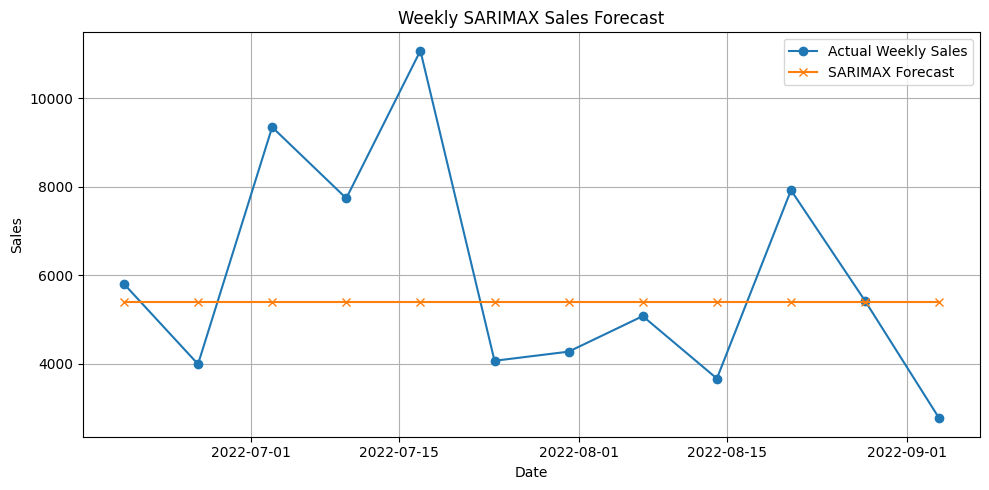

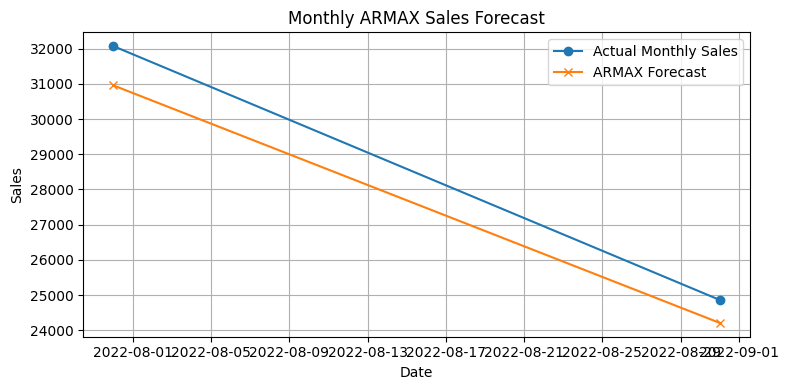

In [13]:
plt.figure(figsize=(10,5))
plt.plot(test_w['Date'], test_w['Sales'], marker='o', label='Actual Weekly Sales')
plt.plot(test_w['Date'], forecast_w, marker='x', label='SARIMAX Forecast')
plt.title('Weekly SARIMAX Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(test_m['Date'], test_m['Sales'], marker='o', label='Actual Monthly Sales')
plt.plot(test_m['Date'], forecast_m, marker='x', label='ARMAX Forecast')
plt.title('Monthly ARMAX Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Weekly AR - MAE: 1953.5232602044864


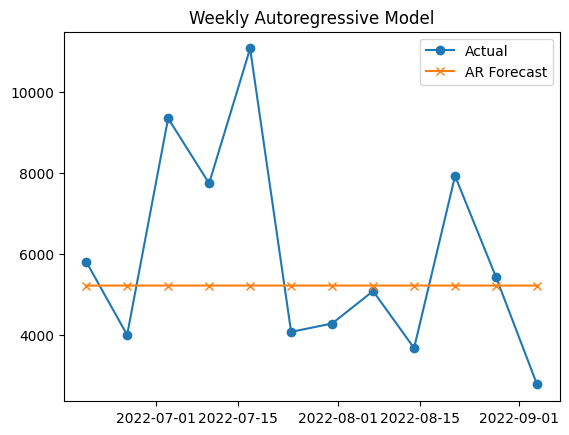

In [17]:
#AR model
from statsmodels.tsa.ar_model import AutoReg

train_w = df_weekly.iloc[:-12]
test_w = df_weekly.iloc[-12:]

model_ar = AutoReg(train_w['Sales'], lags=1).fit()
forecast_ar = model_ar.predict(start=len(train_w), end=len(train_w)+len(test_w)-1)
mae_ar = mean_absolute_error(test_w['Sales'], forecast_ar)
print('Weekly AR - MAE:', mae_ar)
plt.plot(test_w['Date'], test_w['Sales'], marker='o', label='Actual')
plt.plot(test_w['Date'], forecast_ar, marker='x', label='AR Forecast')
plt.legend(); plt.title('Weekly Autoregressive Model')
plt.show()

Weekly MA - MAE: 1953.9511245976635


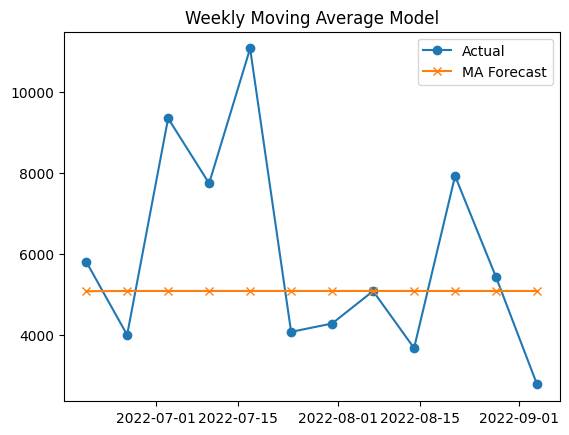

In [18]:
# MA Model
from statsmodels.tsa.arima.model import ARIMA

model_ma = ARIMA(train_w['Sales'], order=(0,0,1)).fit()
forecast_ma = model_ma.forecast(steps=len(test_w))
mae_ma = mean_absolute_error(test_w['Sales'], forecast_ma)
print('Weekly MA - MAE:', mae_ma)
plt.plot(test_w['Date'], test_w['Sales'], marker='o', label='Actual')
plt.plot(test_w['Date'], forecast_ma, marker='x', label='MA Forecast')
plt.legend(); plt.title('Weekly Moving Average Model')
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Weekly ARIMA - MAE: 1980.9996049244874


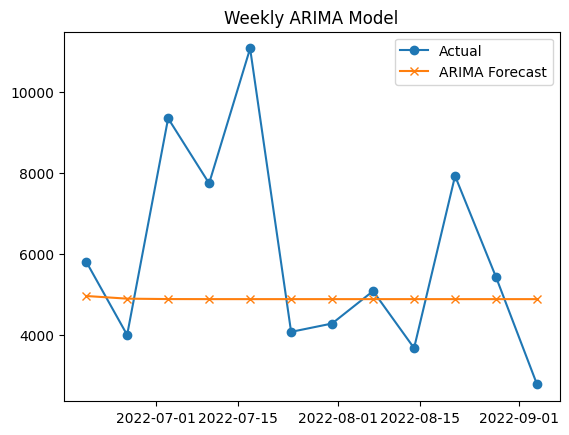

In [19]:
# ARIMA Model (weekly)
model_arima = ARIMA(train_w['Sales'], order=(1,1,1)).fit()
forecast_arima = model_arima.forecast(steps=len(test_w))
mae_arima = mean_absolute_error(test_w['Sales'], forecast_arima)
print('Weekly ARIMA - MAE:', mae_arima)
plt.plot(test_w['Date'], test_w['Sales'], marker='o', label='Actual')
plt.plot(test_w['Date'], forecast_arima, marker='x', label='ARIMA Forecast')
plt.legend(); plt.title('Weekly ARIMA Model')
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Weekly SARIMA - MAE: 1953.4208333333333


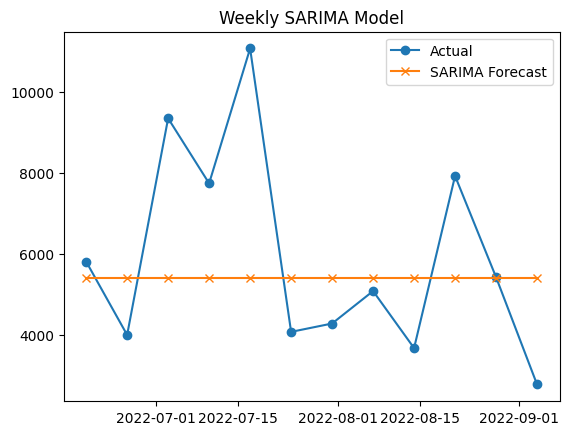

In [20]:
# SARIMA Model
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarima = SARIMAX(train_w['Sales'], order=(1,1,1), seasonal_order=(1,1,1,52)).fit()
forecast_sarima = model_sarima.forecast(steps=len(test_w))
mae_sarima = mean_absolute_error(test_w['Sales'], forecast_sarima)
print('Weekly SARIMA - MAE:', mae_sarima)
plt.plot(test_w['Date'], test_w['Sales'], marker='o', label='Actual')
plt.plot(test_w['Date'], forecast_sarima, marker='x', label='SARIMA Forecast')
plt.legend(); plt.title('Weekly SARIMA Model')
plt.show()